# Data of a complex model with induced magnetization

This notebook generates a toal field anomaly (TFA) and an amplitude of the anomalous magnetic field (AMF) data from a complex model in a regular grid or flightlines.

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando import utils
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from fatiando.gravmag.sphere import tf, bx, by, bz
from fatiando.mesher import Sphere
from fatiando.vis import mpl

### Auxiliary functions

In [146]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

### The model

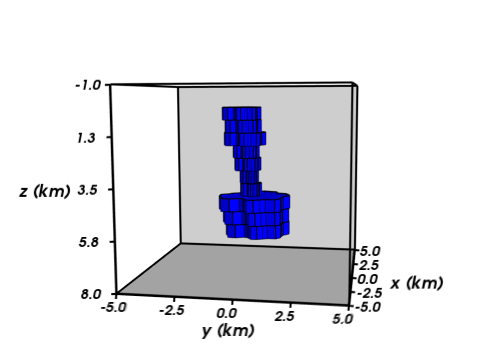

In [147]:
img(filename='data/shallow_true.png')

### Importing model and grid

In [148]:
model_dir = 'data/model.pickle'
grid_dir = '../diorama/diorama_decimated_tfa.txt'

In [149]:
df = pd.read_csv(grid_dir, sep=' ')

In [150]:
xp = df['X'].values - np.mean(df['X'].values)
yp = df['Y'].values - np.mean(df['Y'].values)
zp =  - (df['GPSALT'].values - np.mean(df['GPSALT'].values) + 100.)

In [151]:
np.max(zp)

-6.8694326972665749

In [152]:
with open(model_dir) as w:
        model = pickle.load(w)

In [153]:
data = dict()

In [154]:
data['grid'] = [xp, yp, zp, xp.size, 'flightlines']
mypath = 'data/'

### Adding a sphere

In [155]:
sp = Sphere(100., 100., -400., 50., {'magnetization': utils.ang2vec(100., -21.5, -18.7)})

tfa_sphere = tf(xp, yp, zp, [sp], inc=-21.5, dec=-18.7)

tfa_sphere_up = tf(xp, yp, zp-900., [sp], inc=-21.5, dec=-18.7)

bx_sphere = bx(xp, yp, zp, [sp])
by_sphere = by(xp, yp, zp, [sp])
bz_sphere = bz(xp, yp, zp, [sp])

amf_sphere = np.sqrt(bx_sphere**2. + by_sphere**2. + bz_sphere**2.)

### Generating data

In [156]:
# main field
data['main_field'] = [-21.5, -18.7]

# TFA data
data['tfa'] = polyprism.tf(xp, yp, zp,
                           model['prisms'], data['main_field'][0], data['main_field'][1]) # predict data

data['tfa2'] = data['tfa'] + tfa_sphere

amp_noise = 5.
data['tfa_obs'] = data['tfa'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size) # noise corrupted tfa data
data['tfa2_obs'] = data['tfa2'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size)

In [157]:
# AMF data
data['bx'] = polyprism.bx(xp, yp, zp, model['prisms'])
data['by'] = polyprism.by(xp, yp, zp, model['prisms'])
data['bz'] = polyprism.bz(xp, yp, zp, model['prisms'])

data['amf'] = np.sqrt(data['bx']**2. + data['by']**2. + data['bz']**2.)

data['amf2'] = data['amf'] + amf_sphere

data['amf_obs'] = data['amf'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size) # noise corrupted amf data
data['amf2_obs'] = data['amf2'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size) # noise corrupted amf data

In [158]:
# main field
data['main_field'] = [-21.5, -18.7]

# TFA data - upward continuation
data['tfa_upward'] = polyprism.tf(xp, yp, np.zeros_like(xp) - 1000., \
                           model['prisms'], data['main_field'][0], data['main_field'][1]) # predict data
data['tfa2_upward'] = data['tfa_upward'] + tfa_sphere_up
amp_noise = 1.
data['tfa_upward_obs'] = data['tfa_upward'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size) # noise corrupted tfa data
data['tfa2_upward_obs'] = data['tfa_upward'] + np.random.normal(loc=0., scale=amp_noise,
                               size=xp.size)

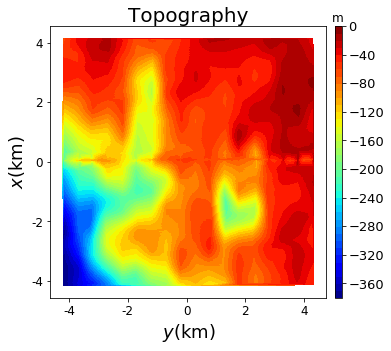

In [159]:
plt.figure(figsize=(6,5))
plt.title('Topography', fontsize=20)
plt.tricontourf(yp, xp, zp, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('m')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/topo.png', dpi=300)

### Data ploting

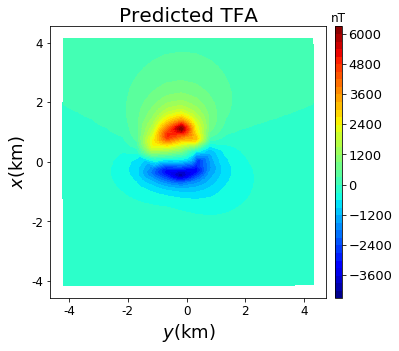

In [160]:
plt.figure(figsize=(6,5))
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, data['tfa'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/pre_tfa.png', dpi=300)

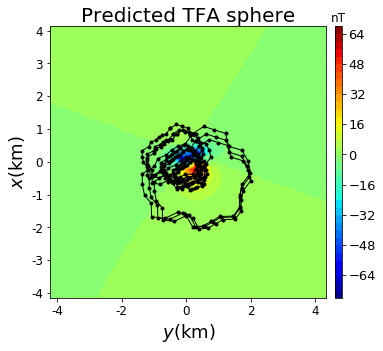

In [161]:
plt.figure(figsize=(6,5))
plt.title('Predicted TFA sphere', fontsize=20)
plt.tricontourf(yp, xp, tfa_sphere, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
for s in model['prisms']:
    source = mpl.polygon(s, '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/pre_tfa_sphere.png', dpi=300)

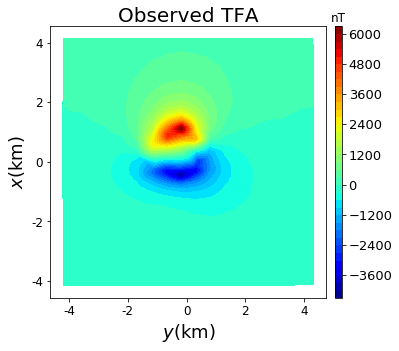

In [162]:
plt.figure(figsize=(6,5))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, data['tfa_obs'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/obs_tfa.png', dpi=300)

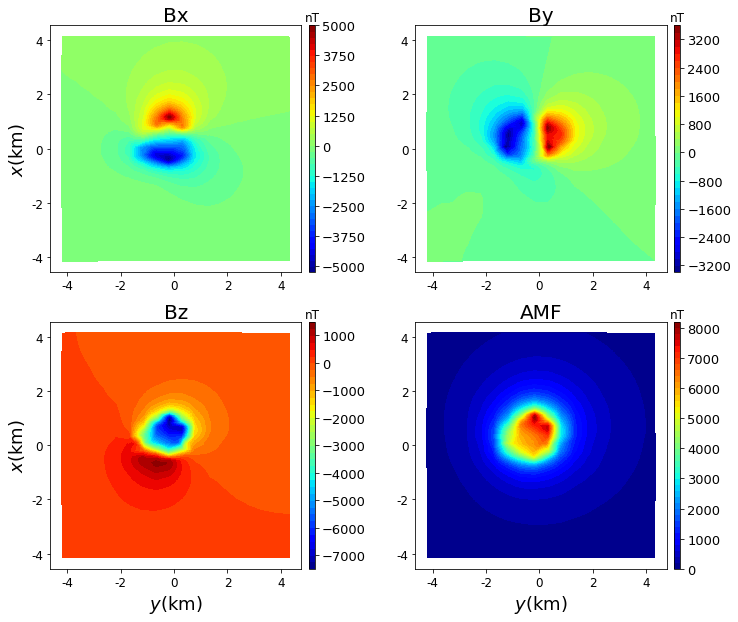

In [163]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.title('Bx', fontsize=20)
plt.tricontourf(yp, xp, data['bx'], 40, cmap='jet').ax.tick_params(labelsize=12)
#plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,2)
plt.title('By', fontsize=20)
plt.tricontourf(yp, xp, data['by'], 40, cmap='jet').ax.tick_params(labelsize=12)
#plt.xlabel('$y$(km)', fontsize=18)
#plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,3)
plt.title('Bz', fontsize=20)
plt.tricontourf(yp, xp, data['bz'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.subplot(2,2,4)
plt.title('AMF', fontsize=20)
plt.tricontourf(yp, xp, data['amf'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
#plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')

plt.savefig(mypath+'/bcomponents_amf.png', dpi=300)


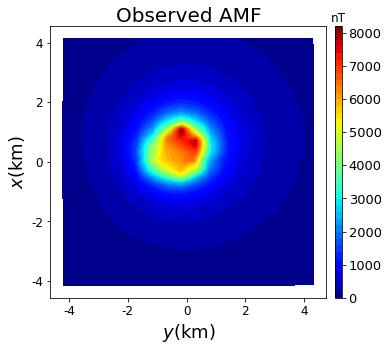

In [164]:
plt.figure(figsize=(6,5))
plt.title('Observed AMF', fontsize=20)
plt.tricontourf(yp, xp, data['amf_obs'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/obs_amf.png', dpi=300)

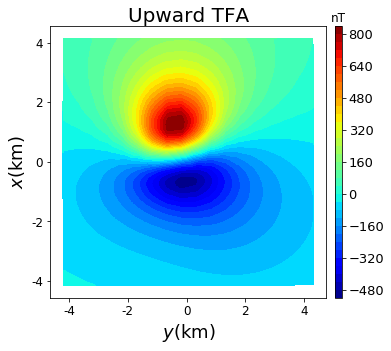

In [165]:
plt.figure(figsize=(6,5))
plt.title('Upward TFA', fontsize=20)
plt.tricontourf(yp, xp, data['tfa_upward'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/up_pre_tfa.png', dpi=300)

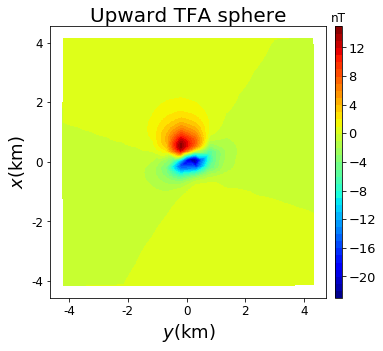

In [166]:
plt.figure(figsize=(6,5))
plt.title('Upward TFA sphere', fontsize=20)
plt.tricontourf(yp, xp, tfa_sphere_up, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/up_pre_tfa_sphere.png', dpi=300)

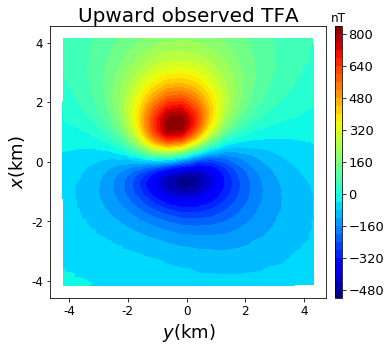

In [167]:
plt.figure(figsize=(6,5))
plt.title('Upward observed TFA', fontsize=20)
plt.tricontourf(yp, xp, data['tfa_upward_obs'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
#source.set_label('Outcropping polygon')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, edgecolor='black')
plt.savefig(mypath+'/up_obs_tfa.png', dpi=300)

### Saving in an outer file

In [168]:
file_name = mypath+'/data.pickle'
with open(file_name, 'w') as f:
    pickle.dump(data, f)